In [90]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [91]:
columns = ['cnt', 'timestamp', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']

df = pd.read_csv('data.csv', usecols=columns)

df['timestamp'] = df['timestamp'].str.slice(10,13)
df['timestamp'] = df['timestamp'].astype(int).astype(str)

In [92]:
from sklearn.model_selection import train_test_split

df['cnt']=np.log1p(df['cnt'])

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.cnt.values
y_val = df_val.cnt.values
y_test = df_test.cnt.values

del df_train['cnt']
del df_val['cnt']
del df_test['cnt']

In [93]:
from sklearn.feature_extraction import DictVectorizer

train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(val_dict)

X_val = dv.transform(val_dict)

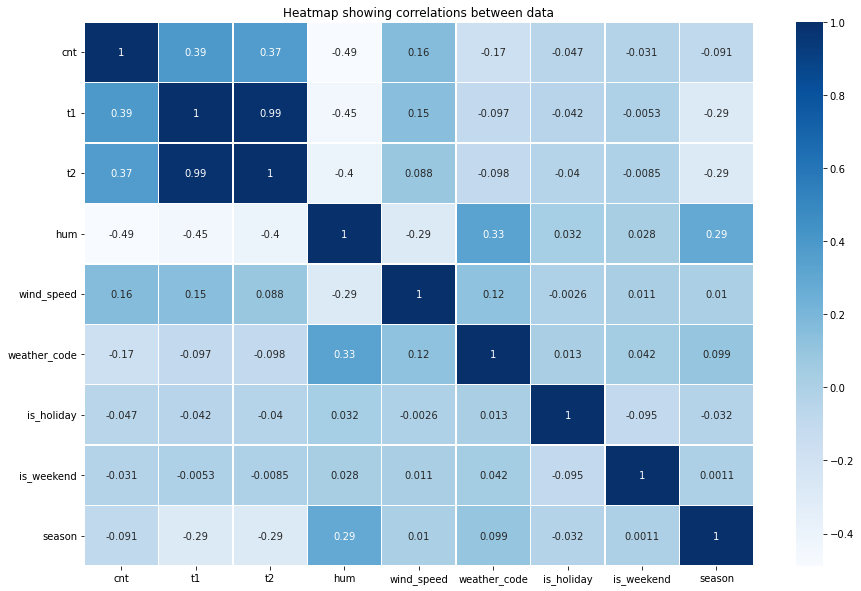

cnt           cnt             1.000000
t1            t1              1.000000
is_weekend    is_weekend      1.000000
is_holiday    is_holiday      1.000000
weather_code  weather_code    1.000000
                                ...   
hum           t2             -0.403495
t1            hum            -0.447781
hum           t1             -0.447781
              cnt            -0.488664
cnt           hum            -0.488664
Length: 81, dtype: float64

In [94]:
plt.figure(figsize=(15,10))  
sns.heatmap(df.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between data')
plt.show()

df.corr().unstack().sort_values(ascending = False)


In [95]:
from sklearn.metrics import mean_squared_log_error

def rmse(y_true, y_pred):
	return(np.sqrt(mean_squared_log_error(y_true, y_pred)))

In [96]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=dv.get_feature_names()))

|--- hum <= 69.75
|   |--- value: [7.15]
|--- hum >  69.75
|   |--- value: [6.01]



/home/kenwu/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [97]:
from sklearn.ensemble import RandomForestRegressor
scores = []
ns = [10, 20, 30, 40, 50, 100]

for n in ns:
    rf = RandomForestRegressor(n_estimators = n, random_state = 1, n_jobs = -1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = rmse(y_val, y_pred)
    scores.append((n,score))

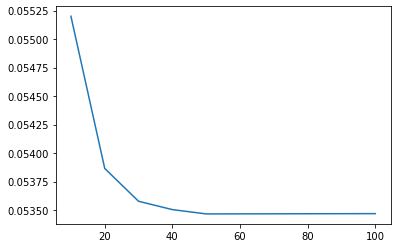

In [98]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [99]:
from sklearn.ensemble import RandomForestRegressor
scores = []
depths = [10, 15, 20, 25, 50, 100]
n = 100

for d in depths:
    rf = RandomForestRegressor(n_estimators = n, max_depth = d, random_state = 1, n_jobs = -1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = rmse(y_val, y_pred)
    scores.append((d,score))

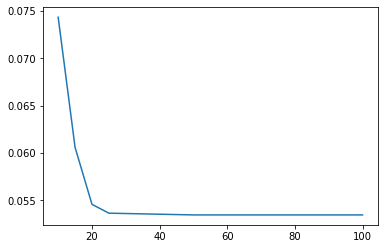

In [100]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'rmse'])
plt.plot(df_scores.max_depth, df_scores.rmse)
d = 100

In [101]:
rf = RandomForestRegressor(n_estimators = n, max_depth = d, random_state = 1, n_jobs = -1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(rmse(y_val, y_pred))

0.05346857184387978


In [103]:
import xgboost as xgb

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

/home/kenwu/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [104]:
scores = []
etas = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

for eta in etas:
    xgb_params['eta'] = eta
    model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals = watchlist)
    y_pred = model.predict(dval)
    rmse_score = rmse(y_val, y_pred)
    scores.append((eta,rmse_score))

[0]	train-rmse:6.01599	val-rmse:6.02723
[1]	train-rmse:5.95683	val-rmse:5.96786
[2]	train-rmse:5.89828	val-rmse:5.90908
[3]	train-rmse:5.84032	val-rmse:5.85092
[4]	train-rmse:5.78294	val-rmse:5.79340
[5]	train-rmse:5.72615	val-rmse:5.73639
[6]	train-rmse:5.66994	val-rmse:5.67998
[7]	train-rmse:5.61428	val-rmse:5.62416
[8]	train-rmse:5.55921	val-rmse:5.56888
[9]	train-rmse:5.50469	val-rmse:5.51414
[10]	train-rmse:5.45072	val-rmse:5.45997
[11]	train-rmse:5.39730	val-rmse:5.40635
[12]	train-rmse:5.34443	val-rmse:5.35331
[13]	train-rmse:5.29208	val-rmse:5.30077
[14]	train-rmse:5.24028	val-rmse:5.24878
[15]	train-rmse:5.18900	val-rmse:5.19733
[16]	train-rmse:5.13823	val-rmse:5.14638
[17]	train-rmse:5.08800	val-rmse:5.09593
[18]	train-rmse:5.03828	val-rmse:5.04601
[19]	train-rmse:4.98904	val-rmse:4.99660
[20]	train-rmse:4.94033	val-rmse:4.94770
[21]	train-rmse:4.89211	val-rmse:4.89928
[22]	train-rmse:4.84437	val-rmse:4.85135
[23]	train-rmse:4.79713	val-rmse:4.80392
[24]	train-rmse:4.75036	va

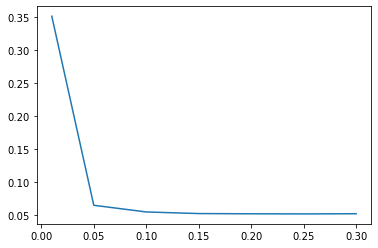

In [105]:
df_scores = pd.DataFrame(scores, columns=['eta', 'rmse'])
plt.plot(df_scores.eta, df_scores.rmse)

In [106]:
scores = []
max_depth = [5, 10 , 15, 20]

for depth in max_depth:
    xgb_params['eta'] = 0.3
    xgb_params['max_depths'] = depth
    model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals = watchlist)
    y_pred = model.predict(dval)
    rmse_score = rmse(y_val, y_pred)
    scores.append((depth,rmse_score))

[19:32:33] WARNING: ../src/learner.cc:576: 
Parameters: { "max_depths" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:4.28865	val-rmse:4.29327
[1]	train-rmse:3.04820	val-rmse:3.04898
[2]	train-rmse:2.19034	val-rmse:2.18994
[3]	train-rmse:1.59828	val-rmse:1.59893
[4]	train-rmse:1.18734	val-rmse:1.18833
[5]	train-rmse:0.91321	val-rmse:0.91662
[6]	train-rmse:0.73299	val-rmse:0.74057
[7]	train-rmse:0.61515	val-rmse:0.62761
[8]	train-rmse:0.53997	val-rmse:0.55640
[9]	train-rmse:0.48090	val-rmse:0.50295
[10]	train-rmse:0.44744	val-rmse:0.47392
[11]	train-rmse:0.42383	val-rmse:0.45408
[12]	train-rmse:0.40698	val-rmse:0.43891
[13]	train-rmse:0.39123	val-rmse:0.42528
[14]	train-rmse:0.36158	val-rmse:0.39841
[15]	train-rmse:0.35132	val-rmse:0

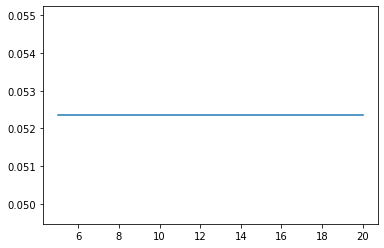

In [107]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'rmse'])
plt.plot(df_scores.max_depth, df_scores.rmse)

In [108]:
scores = []
min_child_weights = [5, 6 , 7, 8, 9, 10]

for weight in min_child_weights:
    xgb_params['min_child_weights'] = weight
    model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals = watchlist)
    y_pred = model.predict(dval)
    rmse_score = rmse(y_val, y_pred)
    scores.append((weight,rmse_score))

[19:32:43] WARNING: ../src/learner.cc:576: 
Parameters: { "max_depths", "min_child_weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:4.28865	val-rmse:4.29327
[1]	train-rmse:3.04820	val-rmse:3.04898
[2]	train-rmse:2.19034	val-rmse:2.18994
[3]	train-rmse:1.59828	val-rmse:1.59893
[4]	train-rmse:1.18734	val-rmse:1.18833
[5]	train-rmse:0.91321	val-rmse:0.91662
[6]	train-rmse:0.73299	val-rmse:0.74057
[7]	train-rmse:0.61515	val-rmse:0.62761
[8]	train-rmse:0.53997	val-rmse:0.55640
[9]	train-rmse:0.48090	val-rmse:0.50295
[10]	train-rmse:0.44744	val-rmse:0.47392
[11]	train-rmse:0.42383	val-rmse:0.45408
[12]	train-rmse:0.40698	val-rmse:0.43891
[13]	train-rmse:0.39123	val-rmse:0.42528
[14]	train-rmse:0.36158	val-rmse:0.39841
[15]	train-rm

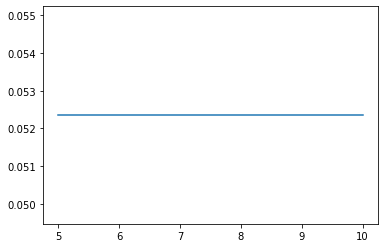

In [109]:
df_scores = pd.DataFrame(scores, columns=['min_child_weights', 'rmse'])
plt.plot(df_scores.min_child_weights, df_scores.rmse)